# Exp.4 Linear regression to derive unbalanced power contribution of each line on data bus

- Dataset: ASCADv1 fixed key
- Input: 8 variables, each bit of chosen $snr$.
- #samples: 50,000
- Target: observed trace's amplitude on highest SNR indice corresponding to $snr2$ to $snr5$
- Target preprocess: Z-score mormalization
- Model: Linear regression (sklearn.linear_model.LinearRegression)

| $snr$ # | Index |
| ---     | ---   |
| 2       | 492   |
| 3       | 149   |
| 4       | 517   |
| 5       | 156   |

In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle
import kan

os.chdir('/workspace')
import src

In [2]:
p = 156
snr = 5
with hydra.initialize(config_path="../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN1h_reg",
            "model.train_params.steps=5000",
            "dataset@train=ASCADf_profiling",
            "dataset@test=ASCADf_attack",
            "trace_transforms=set_poi",
            f"trace_transforms.transforms.0.pois=[[{p}, {p+1}, 1]]",
            "trace_transforms.output_size=1",
            "label_transforms=multilabel_snr",
            f"label_transforms.target_snr={snr}",
            f"save_path=/workspace/notebook/results/exp5/{p}",
            "n_attack_traces=2000"
            ]
        )

In [3]:
device = torch.device('cuda')
cpu = torch.device('cpu')

In [4]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

In [5]:
# Swap trace and label
tmp = KANds['train_input']
KANds['train_input'] = KANds['train_label']
KANds['train_label'] = tmp
tmp = KANds['test_input']
KANds['test_input'] = KANds['test_label']
KANds['test_label'] = tmp

In [6]:
KANds['train_input'].device

device(type='cuda', index=0)

In [7]:
import sklearn
model = sklearn.linear_model.LinearRegression().fit(KANds['train_input'].to(cpu).numpy(), KANds['train_label'].to(cpu).numpy())

In [8]:
model.score(KANds['train_input'].to(cpu).numpy(), KANds['train_label'].to(cpu).numpy())

0.5522077679634094

In [9]:
model.coef_, model.intercept_

(array([[0.8748629 , 0.92139566, 0.32826728, 0.52907753, 0.29187694,
         0.22176011, 0.2137754 , 0.20110516]], dtype=float32),
 array([-1.7891475], dtype=float32))

In [10]:
y = model.predict(KANds['train_input'].to(cpu).numpy())
t = KANds['train_label'].to(cpu).numpy()
loss = np.mean(y-t)
loss

-3.3149718e-08

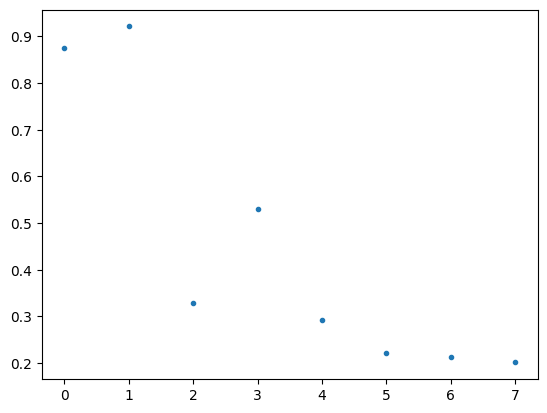

In [11]:
plt.plot(np.abs(model.coef_.reshape(-1)), '.')